In [2]:
import pandas as pd
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import date
from sqlalchemy import create_engine
import os
import boto3

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
!pip install awswrangler

  Obtaining dependency information for awswrangler from https://files.pythonhosted.org/packages/eb/7f/3f0296b736de88a8b5c918e41053c69948a200939106a4e1fd64c5925c6a/awswrangler-3.3.0-py3-none-any.whl.metadata
  Using cached awswrangler-3.3.0-py3-none-any.whl.metadata (23 kB)
  Obtaining dependency information for typing-extensions<5.0.0,>=4.4.0 from https://files.pythonhosted.org/packages/ec/6b/63cc3df74987c36fe26157ee12e09e8f9db4de771e0f3404263117e75b95/typing_extensions-4.7.1-py3-none-any.whl.metadata
  Using cached typing_extensions-4.7.1-py3-none-any.whl.metadata (3.1 kB)
  Obtaining dependency information for urllib3<1.27,>=1.25.4 from https://files.pythonhosted.org/packages/c5/05/c214b32d21c0b465506f95c4f28ccbcba15022e000b043b72b3df7728471/urllib3-1.26.16-py2.py3-none-any.whl.metadata
  Using cached urllib3-1.26.16-py2.py3-none-any.whl.metadata (48 kB)
Using cached awswrangler-3.3.0-py3-none-any.whl (394 kB)
Using cached typing_extensions-4.7.1-py3-none-any.whl (33 kB)
Using cached

In [4]:
import awswrangler as wr

In [73]:
query = """

with base_campanhas as (
select * from (
select 
activityname --jornada campanha
, journeyname --campanha
, subject
, id_customer
, sum(nr_click) as cliques
, sum(nr_open) as aberturas
, min(dt_envio) as dt_envio
from 
martech_curated_zone.retorno_email_sfmc
where eventtype = 'Sent'
and tipo <> 'Transacional'
group by 1,2,3,4
union all 
select 
communication_name as activityname --jornada campanha
, communication_name as journeyname --campanha
, subject
, cl.id_customer
, sum(clicks) as cliques
, sum(opens) as aberturas
, min(send_at) as dt_envio
from 
martech_curated_zone.log_infobip_email_pag p
inner join growth_curated_zone.clientes cl on (cl.email = p."to")
where status = 'Delivered'
group by 1,2,3,4
)
where lower(journeyname) not like '%%cobranca%%'
and lower(journeyname) not like '%%cobrança%%'
and lower(journeyname) not like '%%aquisicao%%'
and lower(journeyname) not like '%%aquisição%%'
and lower(subject) not like '%%willclipping%%' 
and lower(subject) not like '%%relatório%%'
and lower(subject) not like '%%boletim%%'
and lower(subject) not like '%%correios%%'
and lower(subject) not like '%%newsletter%%'
and lower(journeyname) not like '%%teste%%'
and lower(subject) not like '%%teste%%'
and lower(journeyname) not like '%%pesquisa%%'
and lower(journeyname) not like '%%comunicação interna%%'
and lower(journeyname) not like '%%café%%'
and lower(journeyname) not like '%%cxm%%'
and lower(journeyname) not like '%%acesso%%'
and lower(subject) not like '%%[will bank e pag%%'
and lower(subject) not like '%%[willbank]%%'
and lower(subject) not like '%%[meu pag]%%'
and lower(subject) not like '%%[meupag]%%'
and lower(subject) not like '%%[will bank]%%'
and lower(subject) not like '%%pag amarelo%%'
and lower(journeyname) not like '%%unresolved communication%%'
and lower(subject) not like '%%certificado%%'
and lower(journeyname) not like '%%ri_pessoas%%'
and lower(subject) not like '%%will em um minuto%%'
and lower(subject) not like '%%chegaram os vouchers%%'
and dt_envio >= to_date('2023-01-01','yyyy-mm-dd')
)
, conversao_cartao as (
select distinct id_cliente,  dt_data
from platform_curated_zone.transaction_dedicada_spending 
where dt_data >= to_date('2023-01-01','yyyy-mm-dd')
)
, flags_principais as (
select
coalesce(b.id_customer, ct.id_cliente) as id_customer,
date_trunc('month', coalesce(c.dt_envio, ct.dt_data)) as mes_ref,
case when c.id_customer is null then 0 else 1 end as f_tratamento,
case when ct.id_cliente is null then 0 else 1 end as f_conversao,
case when c.aberturas > 0 then 1 else 0 end as f_comunicacao
from customer_analytics_zone.ca_analitico_basao_crm b 
left join base_campanhas c on (c.id_customer = b.id_customer)
left join conversao_cartao ct on (ct.id_cliente = c.id_customer and date_diff('day', c.dt_envio, ct.dt_data) <= 7 and date_diff('day', c.dt_envio, ct.dt_data) > 0 )
)
, com_aleatorizacao as (
select 
*
--, row_number() over (partition by f_tratamento, f_conversao order by rand()) as ordem
, row_number() over (partition by f_tratamento order by rand()) as ordem
from flags_principais
)
select 
b.id_customer
, b.f_tratamento, b.f_conversao, b.f_comunicacao
, c.pc_iu_ult_mes
, c.pc_iu_mes_atual
, c.vl_spending_medio_3m
, c.ds_classif_application
, c.ds_classif_behavior
, c.ds_classif_compra_online
, c.nr_score_ie_credito
, c.nr_score_ie_conta
, c.ds_rfe_credito
, c.ds_persona
, c.ds_perfil_research
, c.ds_seg_consumo
from 
com_aleatorizacao b
left join customer_analytics_zone.ca_analitico_basao_crm c on (c.id_customer = b.id_customer)
where ordem <= 100000


"""

In [74]:
staging_path = 's3://will-prod-ml-platform-sagemaker-studio/staging/flavia-costa/'
boto3_session = boto3.Session(region_name='sa-east-1')


# Clean temporary folder
wr.s3.delete_objects(staging_path, boto3_session=boto3_session)

# Run query
print('Started query')

df = wr.athena.read_sql_query(
    sql=query,
    database=None,
    unload_approach=True,
    ctas_approach=False,
    boto3_session=boto3_session,
    s3_output=staging_path
)
wr.s3.delete_objects(staging_path, boto3_session=boto3_session)


Started query


In [75]:
len(df)

200000

In [26]:
df.dtypes

id_customer                  string
f_tratamento                  Int32
f_conversao                   Int32
f_comunicacao                 Int32
pc_iu_ult_mes               float64
pc_iu_mes_atual             float64
vl_spending_medio_3m        float64
ds_classif_application       string
ds_classif_behavior          string
ds_classif_compra_online     string
nr_score_ie_credito         float64
nr_score_ie_conta           float64
ds_rfe_credito               string
ds_persona                   string
ds_perfil_research           string
ds_seg_consumo               string
dtype: object

In [76]:
id_columns = ['id_customer']
cat_columns = df.drop(id_columns, axis = 1).select_dtypes('string').columns
num_columns = df.drop(id_columns, axis = 1).select_dtypes(exclude=['string']).columns

In [77]:
df.drop(id_columns, axis=1).describe()

,f_tratamento,f_conversao,f_comunicacao,pc_iu_ult_mes,pc_iu_mes_atual,vl_spending_medio_3m,nr_score_ie_credito,nr_score_ie_conta
count,200000.000000,200000.000000,200000.000000,115843.000000,72426.000000,115812.0,161387.000000,103765.000000
mean,0.500000,0.206010,0.085975,0.840056,0.775106,inf,34.782901,47.672816
std,0.500001,0.404439,0.280328,0.399817,0.413657,NaN,31.604763,24.198003
min,0.000000,0.000000,0.000000,-0.826900,-0.696200,-400.0,0.000000,7.410000
25%,0.000000,0.000000,0.000000,0.659000,0.520000,267.0,0.000000,27.050000
50%,0.500000,0.000000,0.000000,0.977000,0.920000,612.0,35.593220,46.350000
75%,1.000000,0.000000,0.000000,1.000000,1.000000,1313.0,64.406780,67.040000
max,1.000000,1.000000,1.000000,31.930000,35.710000,inf,100.000000,99.910000


In [78]:
df['f_tratamento'].value_counts()

0    100000
1    100000
Name: f_tratamento, dtype: Int64

In [79]:
df['f_conversao'].value_counts()

0    158798
1     41202
Name: f_conversao, dtype: Int64

In [80]:
pd.crosstab(df.f_conversao, df.f_tratamento)

f_tratamento,0,1
f_conversao,,
0,100000,58798
1,0,41202


In [81]:
df[['f_tratamento', 'f_conversao']].groupby('f_tratamento').mean()

,f_conversao
f_tratamento,
0,0.0
1,0.41202


In [82]:
df[['f_tratamento', 'f_conversao']].groupby('f_conversao').mean()

,f_tratamento
f_conversao,
0,0.370269
1,1.0


In [33]:
df['f_uplift'] = np.where((df['f_tratamento'] == 1) & (df['f_conversao'] == 1), 1, 0)
df['f_uplift'].value_counts(normalize=True)

0    0.79637
1    0.20363
Name: f_uplift, dtype: float64

In [34]:
for column in df.columns:
    if df[column].dtype == 'object':
        df[column].fillna(df[column].mode()[0], inplace = True)
    elif df[column].dtype == 'string':
        df[column].fillna(df[column].mode()[0], inplace = True)
    elif df[column].dtype != 'object':
        df[column].fillna(df[column].median(), inplace = True)

In [35]:
df.isnull().sum()

id_customer                 0
f_tratamento                0
f_conversao                 0
f_comunicacao               0
pc_iu_ult_mes               0
pc_iu_mes_atual             0
vl_spending_medio_3m        0
ds_classif_application      0
ds_classif_behavior         0
ds_classif_compra_online    0
nr_score_ie_credito         0
nr_score_ie_conta           0
ds_rfe_credito              0
ds_persona                  0
ds_perfil_research          0
ds_seg_consumo              0
f_uplift                    0
dtype: int64

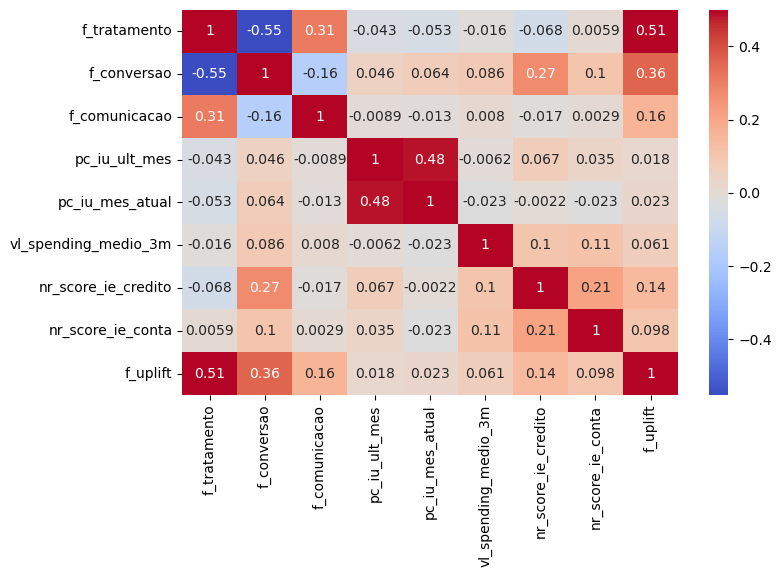

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.heatmap(df.drop(id_columns, axis=1).corr(), annot=True, cmap="coolwarm", vmax=0.5)
plt.show()

In [37]:
df_model = pd.get_dummies(df, columns=cat_columns)

In [38]:
nao_preditor = ['id_customer', 'f_conversao', 'f_uplift', 'f_comunicacao']
target = ['f_conversao']

preditores = df_model.drop(nao_preditor, axis = 1).columns

In [39]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [40]:
x_train, x_test, y_train, y_test = train_test_split(df_model[preditores]
                                                    , df_model[target]
                                                    , random_state=42, test_size=0.20)

In [41]:
x_train = x_train.replace([np.inf, -np.inf], 0)
x_test = x_test.replace([np.inf, -np.inf], 0)

In [42]:
x_test_sim = x_test.copy()

x_test_sim['f_tratamento'] = 0

In [43]:
rf = RandomForestClassifier(n_estimators=200)
rf.fit(x_train, y_train)

/tmp/ipykernel_18/3645670405.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train, y_train)


RandomForestClassifier(n_estimators=200)

In [44]:
y_predicted_clf = rf.predict(x_test)
y_test['f_conversao_predict'] = y_predicted_clf
df_confusion = pd.crosstab(y_test.f_conversao, y_test.f_conversao_predict)

In [55]:
df_confusion

f_conversao_predict,0.0,1.0
f_conversao,,
0,10117,3125
1,2097,24661


In [56]:
cont = len(y_test)
#falso negativo e positivo
fp = df_confusion.iloc[0,1]
fn = df_confusion.iloc[1,0]
#verdadeiro (true) positivo e negativo
tp = df_confusion.iloc[1,1]
tn = df_confusion.iloc[0,0]
#recall - taxa de captura de positivos
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1 = 2 * (precision * recall) / (precision + recall)
print(f" F1: {f1}")
print(f" Recall: {recall}")
print(f" Precision: {precision}")

 F1: 0.9042607802874744
 Recall: 0.9216309141191419
 Precision: 0.8875332901461167


In [57]:
importance_df = pd.DataFrame(rf.feature_importances_, columns = ['importancia'], index = preditores)
importance_df.sort_values(by='importancia', ascending=False).head(16)

,importancia
f_tratamento,0.227196
vl_spending_medio_3m,0.090465
nr_score_ie_credito,0.082112
pc_iu_ult_mes,0.070085
nr_score_ie_conta,0.049699
pc_iu_mes_atual,0.045110
ds_rfe_credito_03-Cliente maduro - offliner,0.038260
ds_classif_behavior_14,0.018769
ds_classif_compra_online_1,0.016092
ds_rfe_credito_02-Cliente novo - onliner,0.013126


In [58]:
x_test_sim['f_tratamento'].describe()

count    40000.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: f_tratamento, dtype: float64

In [59]:
x_test['f_tratamento'].describe()

count    40000.000000
mean         0.500300
std          0.500006
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: f_tratamento, dtype: float64

In [60]:
y_predicted_clf_sim_proba = rf.predict_proba(x_test_sim)

In [61]:
y_predicted_clf_proba = rf.predict_proba(x_test)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- prediction_actual
- prediction_sim
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


ValueError: X has 216 features, but RandomForestClassifier is expecting 214 features as input.

In [52]:
df_analise = x_test

In [53]:
df_analise['prediction_actual'] = y_predicted_clf_proba[:,1]
df_analise['prediction_sim'] = y_predicted_clf_sim_proba[:,1]

In [54]:
df_analise.head()

,f_tratamento,pc_iu_ult_mes,pc_iu_mes_atual,vl_spending_medio_3m,nr_score_ie_credito,nr_score_ie_conta,ds_classif_application_1,ds_classif_application_10,ds_classif_application_11,ds_classif_application_12,...,ds_seg_consumo_TELECOM - 4,ds_seg_consumo_TELECOM - 5,ds_seg_consumo_VIAGEM - 1,ds_seg_consumo_VIAGEM - 2,ds_seg_consumo_VIAGEM - 3,ds_seg_consumo_VIAGEM - 4,ds_seg_consumo_VIAGEM - 5,ds_seg_consumo_VIAGEM - 6,prediction_actual,prediction_sim
119737,1,0.9745,0.8886,0.0,13.559322,32.11,0,0,0,0,...,0,0,0,0,0,0,0,0,0.030000,0.860000
72272,0,1.0495,0.8886,23.0,8.474576,69.03,0,1,0,0,...,0,0,0,0,0,0,0,0,0.885000,0.885000
158154,0,0.1542,0.2101,717.0,55.932203,13.63,0,0,0,0,...,0,0,0,0,0,0,0,0,0.940000,0.940000
65426,1,0.6640,0.8886,369.0,49.152542,47.57,0,0,0,0,...,0,0,0,0,0,0,0,0,0.390000,0.960000
30074,1,1.0385,1.0004,924.0,77.966102,55.22,0,0,0,0,...,0,0,0,0,0,0,0,0,0.683667,0.986667


In [63]:
#faixa de conversão por probabilidade
#cálculo ks
#ver se a probabilidade de conversão tá invertida
#caso não esteja - dividir em faixas de ate e rodar função de combinações
#rodar regressão logística no pystats

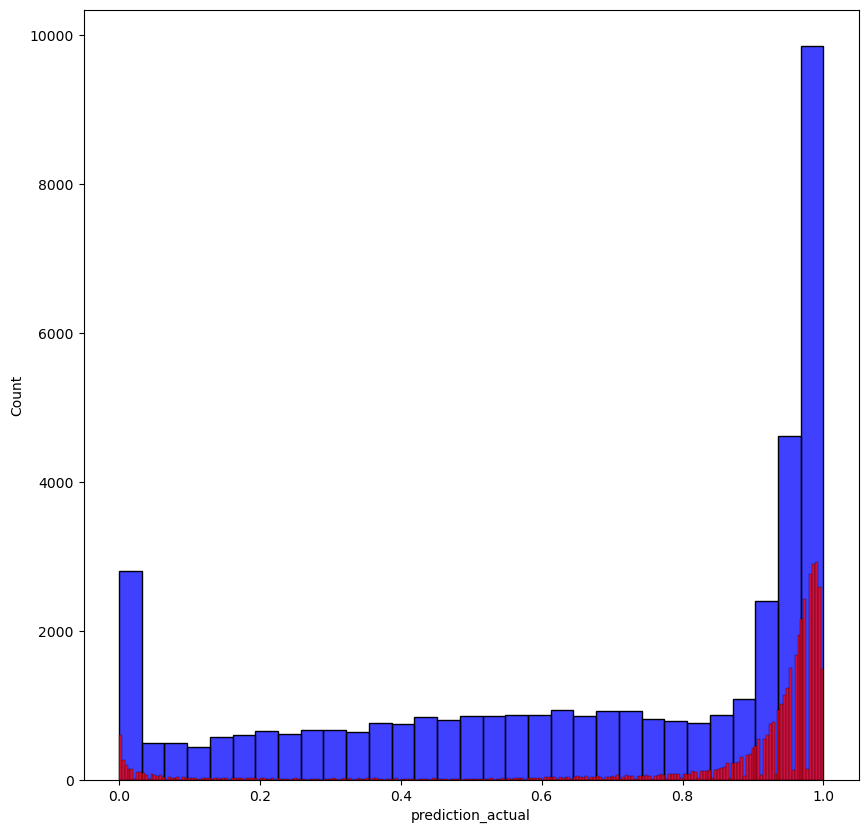

In [62]:
plt.figure(figsize=(10,10))
sns.histplot(data = df_analise, x = 'prediction_actual', color = "blue")
sns.histplot(data = df_analise, x = 'prediction_sim', color = "red")
plt.show()

In [63]:
df_analise['ate'] = df_analise['prediction_actual'] - df_analise['prediction_sim']

In [64]:
df_analise['ate'].describe()

count    40000.000000
mean        -0.203859
std          0.246473
min         -0.875000
25%         -0.420000
50%          0.000000
75%          0.000000
max          0.030000
Name: ate, dtype: float64

<AxesSubplot:xlabel='ate', ylabel='Count'>

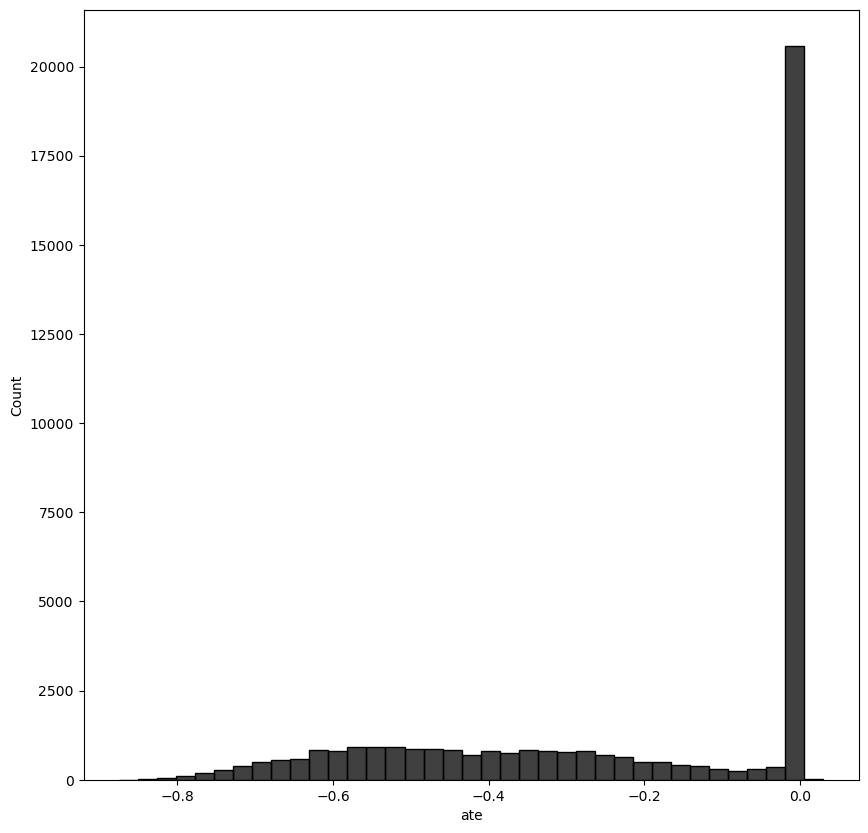

In [65]:
plt.figure(figsize=(10,10))
sns.histplot(data = df_analise, x = 'ate', color = "black")

<AxesSubplot:xlabel='ate', ylabel='Count'>

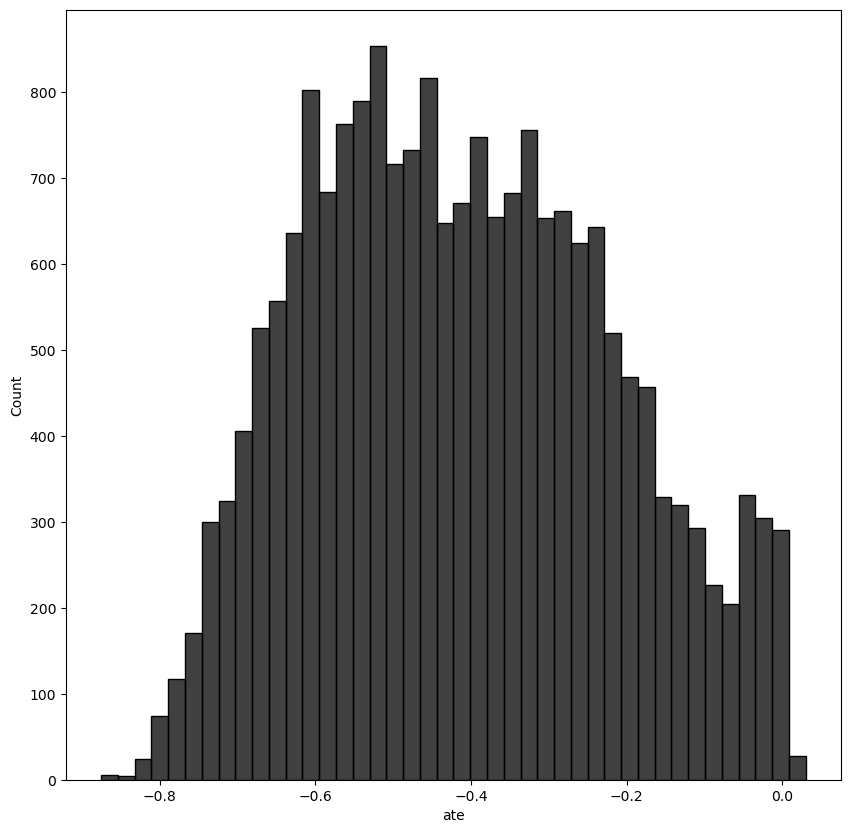

In [66]:
plt.figure(figsize=(10,10))
sns.histplot(data = df_analise.query('ate != 0'), x = 'ate', color = "black")

In [67]:
len(df_analise.query('ate > 0'))

46

In [68]:
len(df_analise.query('ate > 0')) / len(df_analise)

0.00115

In [69]:
len(df_analise.query('ate >= 0'))

20232

In [70]:
len(df_analise.query('ate > -0.10'))0.9042607802874744

21599

In [71]:
df_analise.query('ate != 0')['ate'].describe()

count    19814.000000
mean        -0.411544
std          0.192783
min         -0.875000
25%         -0.565000
50%         -0.425000
75%         -0.270000
max          0.030000
Name: ate, dtype: float64